In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import itertools 
from collections import defaultdict 
from itertools import permutations,combinations
import seaborn as sns

In [2]:
Database = pd.read_csv('Channel_combination.csv')
Database 

,channels_subset,No_of_client
0,"Organic Search,Organic Social,Paid Search",1
1,"Display,Organic Search,Referral",1
2,"Direct,Display,Organic Search",1
3,"Organic Search,Paid Search",91
4,Email,1
5,"(Other),Direct,Email,Organic Search",1
6,Organic Search,383
7,"Direct,Email,Organic Search",2
8,"(Other),Organic Search,Referral",1
9,"Direct,Organic Social,Referral",1


In [3]:
# Create a function that returns all possible combinations of the channel 

def power_set(List): 
    PS = [list(j) for i in range(len(List)) for j in 
    itertools.combinations(List, i+1)]
    return PS

In [4]:
# This function returns all the possible subsets of a set of channels

def subsets(s): 
    if len(s) == 1: 
        return s
    else: 
        sub_channels = []
        for i in range(1, len(s)+1):
            sub_channels.extend(map(list,itertools.combinations(s,i)))
        return list(map(",".join,map(sorted,sub_channels)))

In [5]:
# This function computes the worth of each coalition 
# A: a coalition of all channels 
# C_values: A dictionary containing the number of conversions that 
#           each subset of channels has yielded. 

def v_function(A,C_values): 
    subsets_of_A = subsets(A)
    worth_of_A = 0
    for subset in subsets_of_A: 
        if subset in C_values: 
            worth_of_A += C_values[subset]
    return worth_of_A


In [6]:
# This function calculates the factorial of a number (a non-negative integer)

def factorial(n): 
    if n == 0: 
        return 1 
    else: 
        return n*factorial(n-1)

In [14]:
# This function returns the shapley values

def calculate_shapley(df, col_name):

    c_values = df.set_index("channels_subset").to_dict()[col_name]
    df['channels'] = df['channels_subset'].apply(lambda x: x if len(x.split(",")) == 1 else np.nan)
    channels = list(df['channels'].dropna().unique())
    
    v_values = {}
    for A in power_set(channels):
        v_values[','.join(sorted(A))] = v_function(A,c_values)
    n=len(channels)
    shapley_values = defaultdict(int)

    for channel in channels:
            for A in v_values.keys():
                if channel not in A.split(","):
                    cardinal_A=len(A.split(","))
                    A_with_channel = A.split(",")
                    A_with_channel.append(channel)            
                    A_with_channel=",".join(sorted(A_with_channel))
                    # Weight = |S|!(n-|S|-1)!/n!
                    weight = (factorial(cardinal_A)*factorial(n-cardinal_A-1)/factorial(n))
                    # Marginal contribution = v(S U {i})-v(S)
                    contrib = (v_values[A_with_channel]-v_values[A]) 
                    shapley_values[channel] += weight * contrib
            # Add the term corresponding to the empty set
            shapley_values[channel]+= v_values[channel]/n 
        
    return shapley_values

In [15]:
A = calculate_shapley(Database, 'No_of_client')

In [16]:
print(A)

defaultdict(<class 'int'>, {'Email': 2.7499999999999982, 'Organic Search': 514.9166666666665, 'Paid Search': 149.50000000000006, 'Organic Social': 4.999999999999995, 'Direct': 190.4166666666666, 'Referral': 155.0000000000001, '(Other)': 2.083333333333332, 'Paid Social': 1.3333333333333317})


In [17]:
Attribution_array = pd.DataFrame(list(A.items()), columns=['Channels', 'Values'])
Attribution_array

,Channels,Values
0,Email,2.750000
1,Organic Search,514.916667
2,Paid Search,149.500000
3,Organic Social,5.000000
4,Direct,190.416667
5,Referral,155.000000
6,(Other),2.083333
7,Paid Social,1.333333


In [18]:
Total = Attribution_array['Values'].sum(axis=0)
Total

1021.0

In [19]:
Attribution_array = Attribution_array.assign(Percentage =lambda x: round((x['Values']/Total *100),1))
Attribution_array

,Channels,Values,Percentage
0,Email,2.750000,0.3
1,Organic Search,514.916667,50.4
2,Paid Search,149.500000,14.6
3,Organic Social,5.000000,0.5
4,Direct,190.416667,18.7
5,Referral,155.000000,15.2
6,(Other),2.083333,0.2
7,Paid Social,1.333333,0.1


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Email'),
  Text(1, 0, 'Organic Search'),
  Text(2, 0, 'Paid Search'),
  Text(3, 0, 'Organic Social'),
  Text(4, 0, 'Direct'),
  Text(5, 0, 'Referral'),
  Text(6, 0, '(Other)'),
  Text(7, 0, 'Paid Social')])

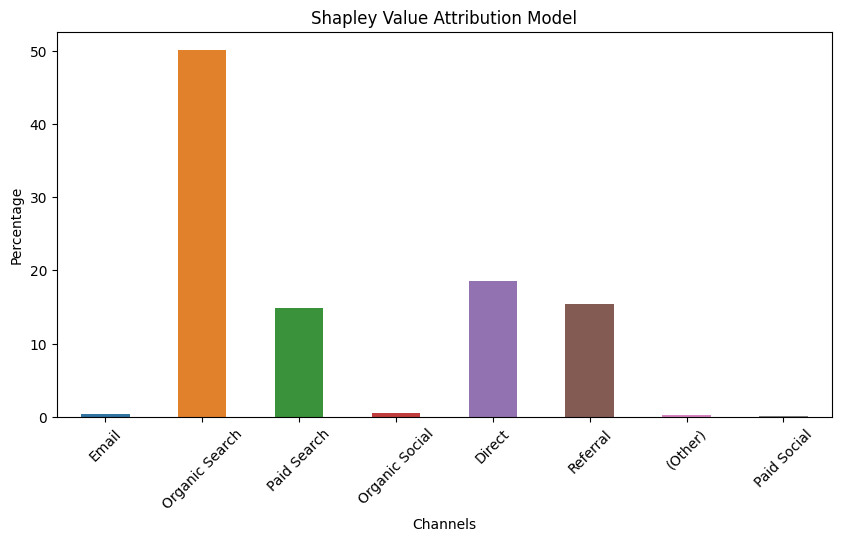

In [13]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x = 'Channels', y = 'Percentage', data = Attribution_array, errwidth=0, width=0.5).set_title('Shapley Value Attribution Model')
plt.xticks(rotation = 45)